## Indexing images in qdrant and Image Retrieval Pipeline

### Extract the images from zipfile to a folder

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/Image_Discoverability_Project/all_3_textbooks_image_dataset.zip'
extraction_folder = '/content/image_dataset'


os.makedirs(extraction_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

print(f"All images have been extracted to {extraction_folder}")

In [ ]:
# Install required packages
# !pip install --upgrade torch torchvision torchaudio
!pip install colpali-engine qdrant-client stamina tqdm ollama requests openai anthropic

In [1]:
# Import all the required packages

import os
from typing import cast, List
from PIL import Image
from colpali_engine.models import ColPali, ColPaliProcessor
from qdrant_client import QdrantClient, models
import stamina
from tqdm import tqdm
import requests as requests
import json
from openai import OpenAI
import base64
import torch

In [10]:
# fetching image paths function
def get_image_paths(folder_path):
  images_paths = [folder_path+'/'+file for file in os.listdir(folder_path)]
  return images_paths

In [11]:
# fetching image paths from images present in folder: /content/image_dataset_2
# <Update the folder path here when run in different system>
image_paths = get_image_paths('/content/image_dataset')
print(f"Number of images in the folder: {len(image_paths)}")

Number of images in the folder: 50


### Load COLPALI EMBEDDING model

In [4]:
#Function to load the COLPALI MODEL
def load_image_embedding_model(model_name):
  model = ColPali.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      device_map="cuda:0",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
  ).eval()

  processor = ColPaliProcessor.from_pretrained(model_name)

  return model, processor

In [5]:
model, processor = load_image_embedding_model("vidore/colpali-v1.2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [50]:
# Function to load the images from the given image paths
def load_images(image_paths: List[str]) -> List[Image.Image]:
    images = []
    for path in image_paths:
        try:
            img = Image.open(path)
            img = img.convert("RGB")
            images.append(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return images

In [51]:
# Function to Encode the image to base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

In [8]:
images = load_images(image_paths)

In [9]:
print(len(image_paths))

50


Qdrant connection Details - Update your specific qdrant url and api

In [52]:
# qdrant connection details
qdrant_url = "https://5655a152-5dfa-4807-9700-f8976170b86f.europe-west3-0.gcp.cloud.qdrant.io:6333"
qdrant_api = "ehg5LrM1GG9BLJ9ShL6hBWH5IGxsD7RJHXNogiJQfiYD-5gONEN5CQ"

# Functions to create and delete qdrant collection

In [13]:
def create_qdrant_client(url, api_key):
  qdrant_client = QdrantClient(
      url=url,
      api_key=api_key,
  )
  return qdrant_client

def delete_qdrant_collection(qdrant_client, collection_name):
  qdrant_client.delete_collection(collection_name=collection_name)

In [14]:
qdrant_client = create_qdrant_client(qdrant_url, qdrant_api)

In [20]:
# delete_qdrant_collection(qdrant_client, collection_name="textbook_image_embeddings_v2")

In [21]:
print(qdrant_client.get_collections())

collections=[CollectionDescription(name='osc_image_embeddings_v1'), CollectionDescription(name='cybersec_image_embeddings_v1')]


In [17]:
def create_qdrant_collection(qdrant_client, collection_name, vector_size, indexing_threshold):
  qdrant_client.create_collection(
      collection_name=collection_name,
      on_disk_payload=True,
      optimizers_config=models.OptimizersConfigDiff(
          indexing_threshold=indexing_threshold
      ),
      vectors_config=models.VectorParams(
          size=vector_size,
          distance=models.Distance.COSINE,
          multivector_config=models.MultiVectorConfig(
              comparator=models.MultiVectorComparator.MAX_SIM
          ),
          quantization_config=models.ScalarQuantization(
              scalar=models.ScalarQuantizationConfig(
                  type=models.ScalarType.INT8,
                  quantile=0.99,
                  always_ram=True,
              ),
          ),
      ),
  )

Function call to create the collection in qdrant - run the below cell only if you need to create collection. Change the collection name as required

In [22]:
# Create qdrant collection with multivector configuration
collection_name = "textbook_image_embeddings_v1"
vector_size = 128
indexing_threshold = 200
create_qdrant_collection(qdrant_client, collection_name, vector_size, indexing_threshold)

In [23]:
print(qdrant_client.get_collections())

collections=[CollectionDescription(name='osc_image_embeddings_v1'), CollectionDescription(name='cybersec_image_embeddings_v1'), CollectionDescription(name='textbook_image_embeddings_v1')]


# QDRANT Functions to insert the embeddings into vector store after embedding using COLPALI MODEL

#NOTE: RUN THE BELOW 3 CELLS ONLY IF YOU NEED TO EMBED THE IMAGES TO QDRANT. SINCE THE IMAGES ARE ALREADY EMBEDDED, PLEASE DO NOT RUN

In [53]:
@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(points, collection_name):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [25]:
def index_images_to_qdrant(images_paths, batch_size, collection_name):
  # Use tqdm to create a progress bar
  with tqdm(total=len(images_paths), desc="Indexing Progress") as pbar:
      for i in range(0, len(images_paths), batch_size):
          batch = images_paths[i : i + batch_size]

          images = load_images(batch)
          # Process and encode images
          print("Image load done")

          with torch.no_grad():
              batch_images = processor.process_images(images).to(
                  model.device
              )
              print("image proccess done")
              image_embeddings = model(**batch_images)

          # Prepare points for Qdrant
          points = []
          for j, embedding in enumerate(image_embeddings):
              # Convert the embedding to a list of vectors
              multivector = embedding.cpu().float().numpy().tolist()
              image_base64 = encode_image(batch[j])

              points.append(
                  models.PointStruct(
                      id=i + j,  # we just use the index as the ID
                      vector=multivector,  # This is now a list of vectors
                      payload={
                          "image": batch[j]
                      },
                  )
              )


          try:
              upsert_to_qdrant(points, collection_name)
          except Exception as e:
              print(f"Error during upsert: {e}")
              continue
          pbar.update(batch_size)

  print("Indexing complete!")

In [26]:
index_images_to_qdrant(image_paths, 2, collection_name)

Indexing Progress:   0%|          | 0/50 [00:00<?, ?it/s]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:   4%|▍         | 2/50 [00:09<03:55,  4.90s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:   8%|▊         | 4/50 [00:17<03:18,  4.31s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  12%|█▏        | 6/50 [00:25<02:59,  4.08s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  16%|█▌        | 8/50 [00:32<02:48,  4.00s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  20%|██        | 10/50 [00:40<02:38,  3.95s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  24%|██▍       | 12/50 [00:48<02:29,  3.93s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  28%|██▊       | 14/50 [00:56<02:23,  3.99s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  32%|███▏      | 16/50 [01:04<02:16,  4.01s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  36%|███▌      | 18/50 [01:12<02:08,  4.01s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  40%|████      | 20/50 [01:20<02:00,  4.02s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  44%|████▍     | 22/50 [01:28<01:51,  4.00s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  48%|████▊     | 24/50 [01:37<01:45,  4.04s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  52%|█████▏    | 26/50 [01:45<01:36,  4.03s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  56%|█████▌    | 28/50 [01:53<01:28,  4.03s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  60%|██████    | 30/50 [02:01<01:20,  4.04s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  64%|██████▍   | 32/50 [02:09<01:12,  4.04s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  68%|██████▊   | 34/50 [02:17<01:04,  4.03s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  72%|███████▏  | 36/50 [02:25<00:56,  4.07s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  76%|███████▌  | 38/50 [02:34<00:50,  4.18s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  80%|████████  | 40/50 [02:42<00:41,  4.13s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  84%|████████▍ | 42/50 [02:50<00:32,  4.12s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  88%|████████▊ | 44/50 [02:58<00:24,  4.10s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  92%|█████████▏| 46/50 [03:06<00:16,  4.08s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress:  96%|█████████▌| 48/50 [03:14<00:08,  4.04s/it]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Image load done
image proccess done


Indexing Progress: 100%|██████████| 50/50 [03:22<00:00,  4.06s/it]

Indexing complete!


# IMAGE RETRIEVAL FUNCTIONS

In [56]:
# Qdrant vector store search for the relevant documents based on user query
def search_images_by_text(query_text, collection_name, top_k=5, colpali_url=None):
  if colpali_url:
    data = {
        "user_query": query_text
    }

    multivector_query = requests.post(colpali_url, data=json.dumps(data))
  else:
    # process and encode the text query
    with torch.no_grad():
        batch_query = processor.process_queries([query_text]).to(
            model.device
        )
        query_embedding = model(**batch_query)

    multivector_query = query_embedding[0].cpu().float().numpy().tolist()

  # search in Qdrant collection
  search_result = qdrant_client.query_points(
      collection_name=collection_name, query=multivector_query, with_payload=["image"], limit=top_k
  )

  row_image_paths = [r.payload["image"] for r in search_result.points]
  return row_image_paths

In [57]:
# Function to display the retreived images
def display_retrieved_images(image_paths):
  for image_path in image_paths:
    print(image_path)
    image = load_images([image_path])[0]
    display(image)

# Image retrieval and displaying the retrieved image

/content/image_dataset_2/Abraham-Silberschatz-Operating-System-Concepts-10th-2018_page-0638.jpg


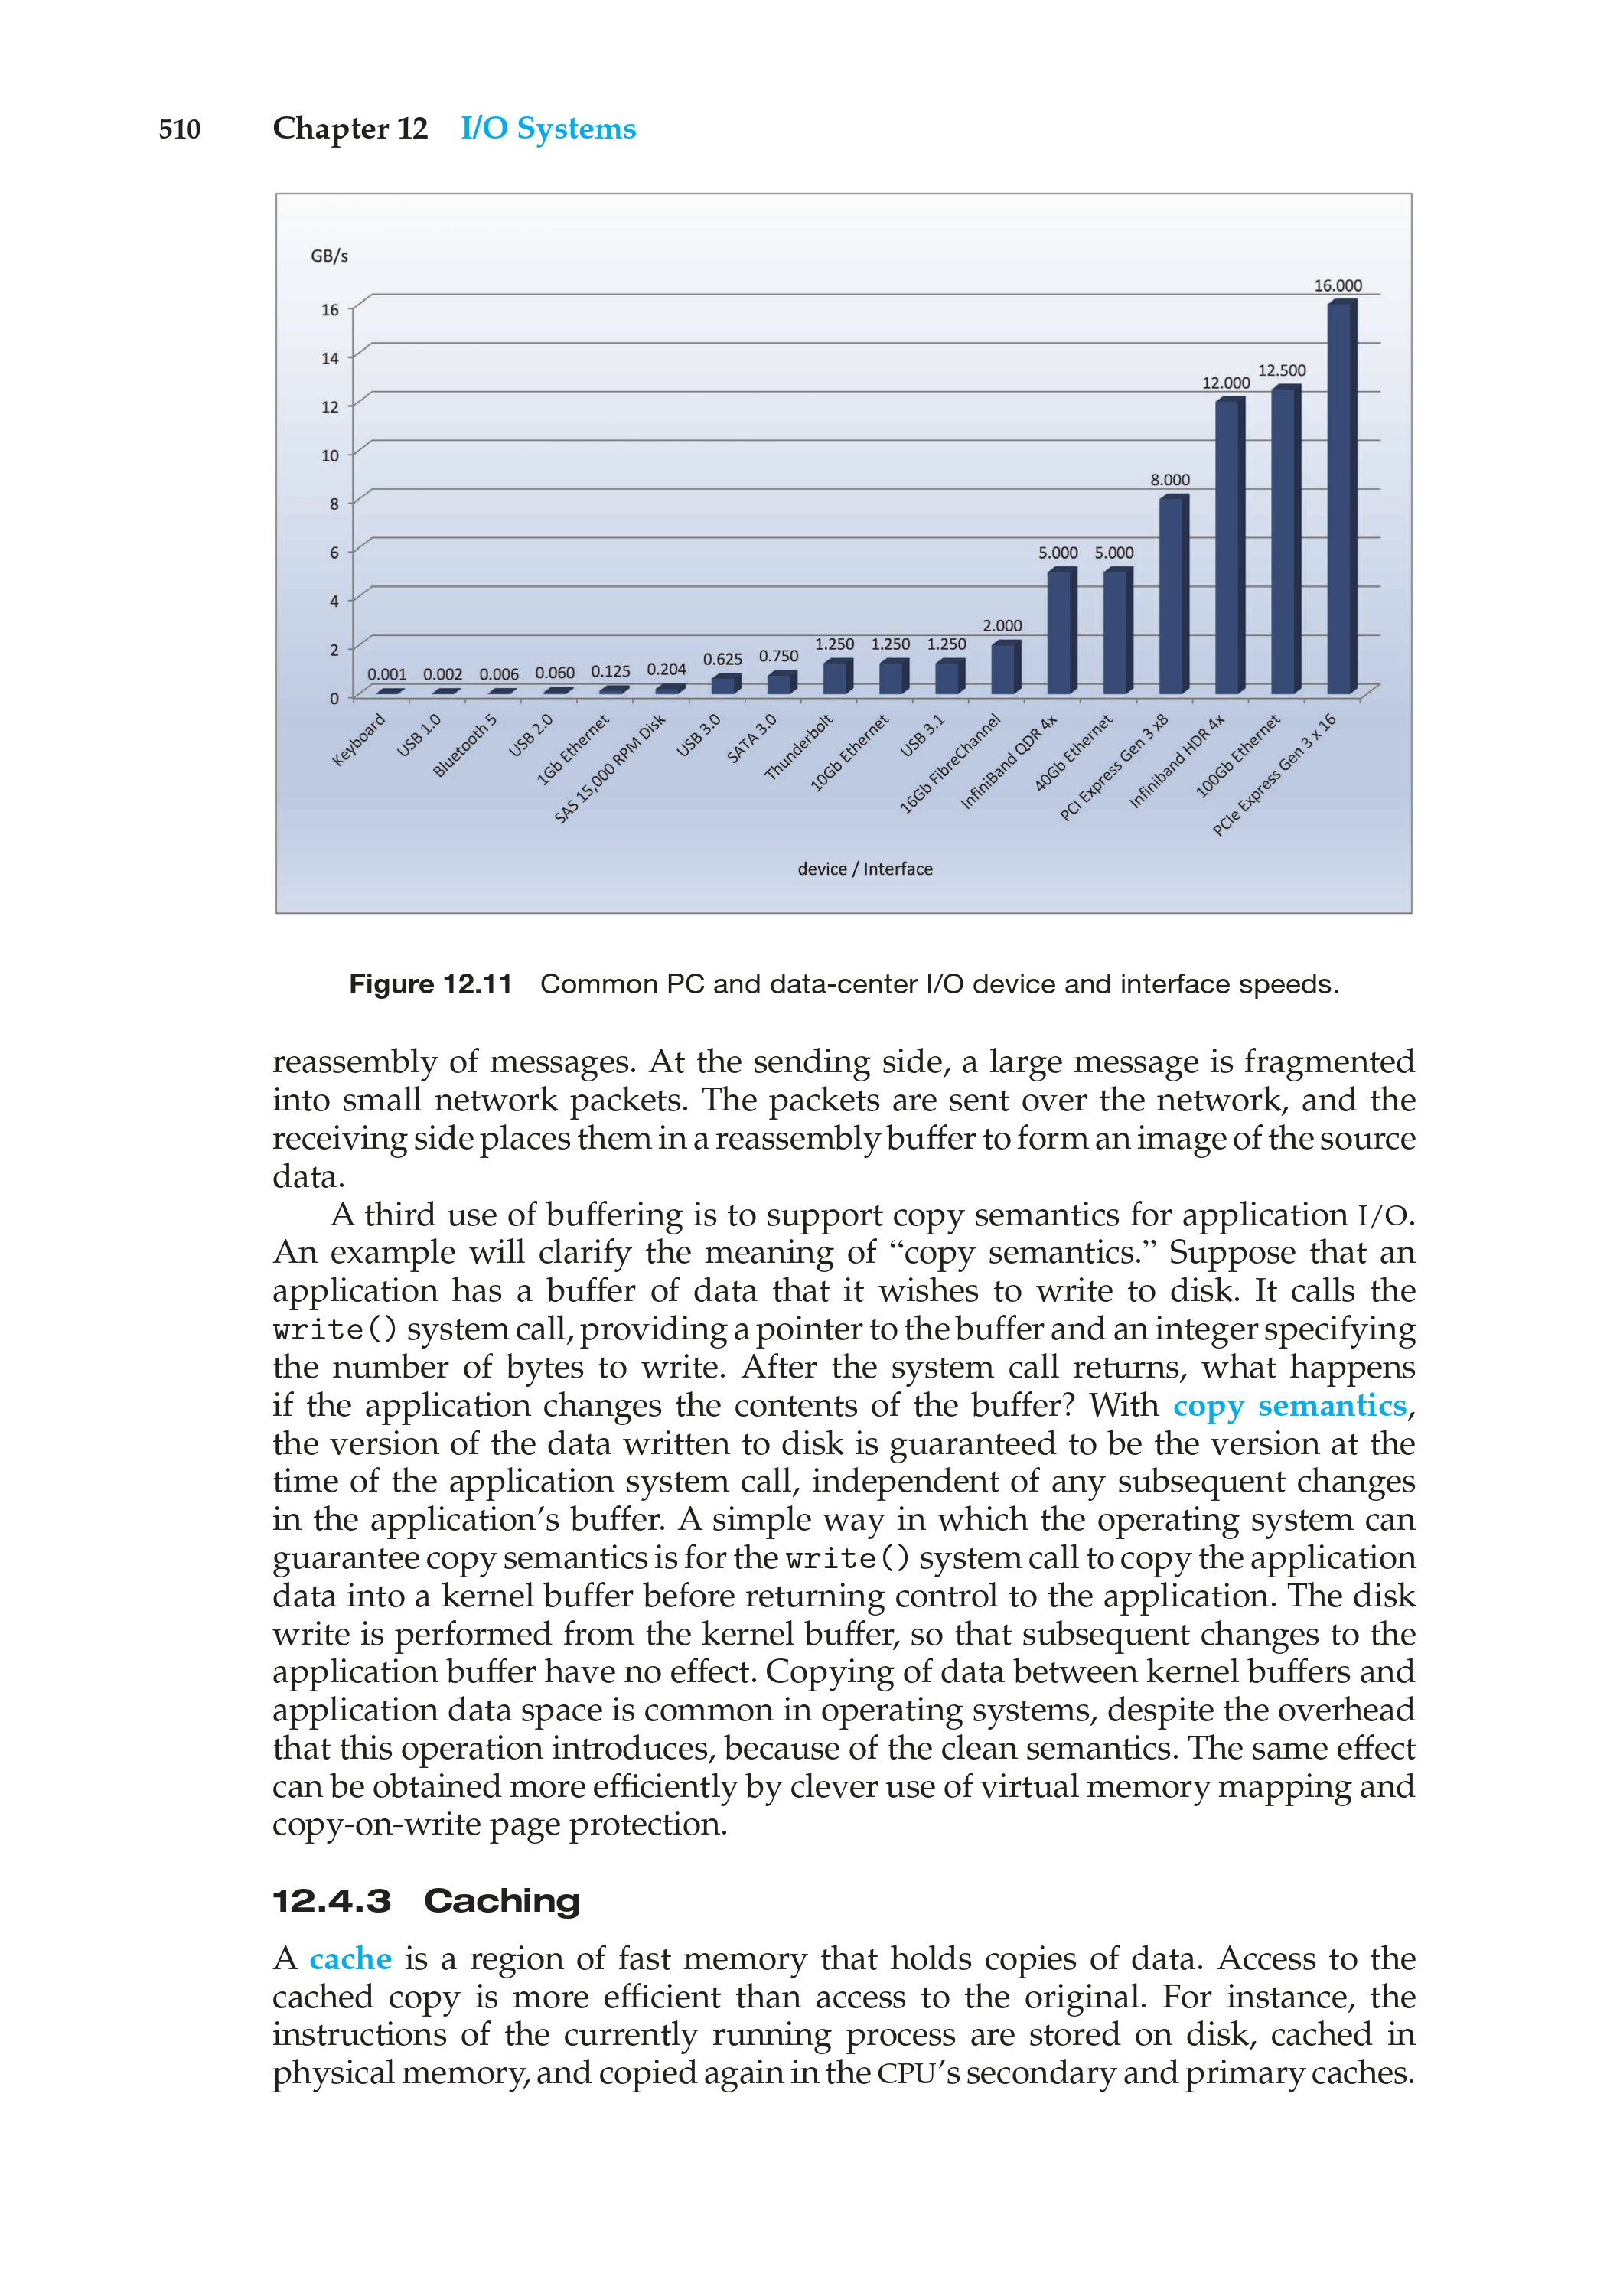

In [45]:
user_query = "What is the data transfer speed of PCIe Express Gen 3x16 compared to PCI Express Gen 3 x8 ?"
# user_query = "What is the data transfer speed of USB 3.0 and USB 3.1 in MB/s?"
# user_query = "Using the binary search tree in figure, what is the result of searching for the value 14, and how many comparisons are made during the search?"
# user_query = "Using the binary search tree in figure, how many leaf nodes does the binary search tree have?"
# user_query = "Which device in the hierarchy has the smallest storage capacity and fastest access time, and which one has the largest storage capacity and slowest access time?"
# user_query = "How does the speedup vary with the number of processing cores for different values (0.05, 0.10, 0.50) of serial fraction (S)?"
# user_query = "What sequence of actions will lead the vacuum agent from the state where both rooms are dirty to the state where both rooms are clean?"
# user_query = "What conditions must be true for the decision to be 'Yes' when the type of restaurant is 'Thai'?"
# user_query = "If there are 'full' patrons, and the person is hungry, what is the next decision based on the type of restaurant?"
# user_query = "At what stage does the kernel determine whether it can satisfy the I/O request without involving the device driver?"
# user_query = "At what point in the communication process does an attacker potentially gain access to the ciphertext?"
# user_query = "What is the output at O1 (carry bit) and X2 (sum) if the inputs are 1, 0, and 1 in the given one-bit full adder circuit?"

results_ds = search_images_by_text(user_query, "textbook_image_embeddings_v1", 1)
display_retrieved_images(results_ds)

# Image retrieval and Generating User query response using one of the vision models

In [39]:
from ollama import Client
import requests
import json

In [41]:
ollama_client = Client(host='http://156.56.180.239:11434') # <Update the URL of the server where Ollama is hosted>
llama_url = "https://uf87fzw07wbj3l-8000.proxy.runpod.net/predict"  # <Update the URL of the server where Llama vision model is hosted>
paligemma_url = "https://wxecoqy3l779f7-8000.proxy.runpod.net/predict" # <Update the URL of the server where paligemma vision model is hosted>

In [42]:
import os
# Using GPT for response generation
# OPENAI API KEY
os.environ["OPENAI_API_KEY"] = "<add your openai api key>"

In [43]:
# Using Claude for response generation
# CLAUDE API KEY
import anthropic
os.environ["ANTHROPIC_API_KEY"] = "<add your claude api key>"

In [44]:
# Function to call the VISION Model API and generate USER QUERY Response
def generate_response(user_query, encoded_images, model_name):
  if model_name == 'ollama-llava':
    response = ollama_client.chat(model='llava', messages=[
      {
        'role': 'user',
        'content': user_query,
        "images":encoded_images
      },
    ])

    print(response['message']['content'])

  elif model_name == 'llama_3.2_vision':
    data = {
        "image_base64": encoded_images[0],
        "user_query": user_query
    }

    response = requests.post(llama_url, data=json.dumps(data))
    output_text = response.json()['output']
    assistant_answer = output_text.split('assistant\n\n')[1]
    return assistant_answer

  elif model_name == 'paligemma':
    data = {
        "image_base64": encoded_images[0],
        "user_query": user_query
    }
    try:
        response = requests.post(paligemma_url, data=json.dumps(data))
        # Check the status code of the response
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
        output_text = response.json()['output']
        return output_text
    except requests.exceptions.RequestException as e:
        print(f"Error communicating with the server: {e}")
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error decoding JSON response or accessing 'output' key: {e}")
        print(f"Raw response content: {response.content}")

  elif model_name == "gpt-4":
    client = OpenAI()
    response = client.chat.completions.create(
      model="gpt-4-turbo",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": user_query,
            },
            {
              "type": "image_url",
              "image_url": {
                "url":  f"data:image/jpeg;base64,{encoded_images[0]}",
                "detail": "high"
              },
            },
          ],
        }
      ],
    )

    return response.choices[0].message.content

  elif model_name == "claude":
    claude_client = anthropic.Client(api_key=os.environ["ANTHROPIC_API_KEY"])
    message = claude_client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": encoded_images[0],
                        },
                    },
                    {
                        "type": "text",
                        "text": user_query
                    }
                ],
            }
        ],
    )
    return message.content[0].text
  else:
    print("Invalid model name provided!")


In [46]:
user_query = "What is the data transfer speed of PCIe Express Gen 3x16 compared to PCI Express Gen 3 x8 ?"
# user_query = "What is the data transfer speed of USB 3.0 and USB 3.1 in MB/s?"
# user_query = "Using the binary search tree in figure, what is the result of searching for the value 14, and how many comparisons are made during the search?"
# user_query = "Using the binary search tree in figure, how many leaf nodes does the binary search tree have?"
# user_query = "Which device in the hierarchy has the smallest storage capacity and fastest access time, and which one has the largest storage capacity and slowest access time?"
# user_query = "How does the speedup vary with the number of processing cores for different values (0.05, 0.10, 0.50) of serial fraction (S)?"
# user_query = "What sequence of actions will lead the vacuum agent from the state where both rooms are dirty to the state where both rooms are clean?"
# user_query = "What conditions must be true for the decision to be 'Yes' when the type of restaurant is 'Thai'?"
# user_query = "If there are 'full' patrons, and the person is hungry, what is the next decision based on the type of restaurant?"
# user_query = "At what stage does the kernel determine whether it can satisfy the I/O request without involving the device driver?"
# user_query = "At what point in the communication process does an attacker potentially gain access to the ciphertext?"
# user_query = "What is the output at O1 (carry bit) and X2 (sum) if the inputs are 1, 0, and 1 in the given one-bit full adder circuit?"

results_ds = search_images_by_text(user_query, "textbook_image_embeddings_v1", 1)
print(results_ds)

result_encode_images = [encode_image(result) for result in results_ds]

['/content/image_dataset_2/Abraham-Silberschatz-Operating-System-Concepts-10th-2018_page-0638.jpg']


In [49]:
res = generate_response(user_query, result_encode_images, "claude") # Vision Model options: gpt-4 or paligemma or llama_3.2_vision or ollama-llava
res

'Looking at the graph, PCIe Express Gen 3x16 has a speed of 16.000 GB/s, while PCI Express Gen 3 x8 shows 8.000 GB/s. Therefore, PCIe Express Gen 3x16 is twice as fast as PCI Express Gen 3 x8, with a difference of 8 GB/s between them.'